# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
numerical = ['num_likes', 'num_comments', 'num_sent', 'sent_avg_length', 'num_words', 
             'num_unique_words', 'unique_words_percent', 'age', 'num_cats',
             'words_exist_per_cent',
             'shortlisted',
             'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 
             'emotion_sadness', 'emotion_surprise', 
             'sentiment_POSITIVE_no_prepro', 'sentiment_NEGATIVE_no_prepro', 
             'sentiment_hf_text']

txt_features = ['text_str', 'text_str_lem']

categories = [   'cat_Age', 'cat_Happy', 'cat_Thriller', 
                 'cat_Friendship', 'cat_East', 'cat_Inspirational', 
                 'cat_Christian', 'cat_Bedtime', 'cat_Drama', 'cat_Horror', 
                 'cat_Lesbian', 'cat_High', 'cat_Science', 'cat_American', 
                 'cat_Speculative', 'cat_Funny', 'cat_Adventure', 
                 'cat_Nonfiction', 'cat_African', 'cat_Christmas', 
                 'cat_Teens', 'cat_Fantasy', 'cat_Holiday', 'cat_Western', 
                 'cat_Young', 'cat_Coming', 'cat_Suspense', 'cat_Romance', 
                 'cat_Urban', 'cat_Latinx', 'cat_Desi', 'cat_Asian', 
                 'cat_Black', 'cat_Sad', 'cat_Kids', 'cat_People', 'cat_Color', 
                 'cat_Fiction', 'cat_Contemporary', 'cat_Mystery', 'cat_Adult', 
                 'cat_Transgender', 'cat_Historical', 'cat_Middle', 'cat_Gay', 
                 'cat_Indigenous', 'cat_Crime', 'num_cats', 'cat_School', 
                 'cat_Creative']

In [3]:
feats_to_keep = numerical + txt_features + categories

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("drive/MyDrive/story_data_new_feats.csv", 
                 usecols=feats_to_keep)
# df = pd.read_csv("story_data_new_feats.csv", 
#                  usecols=feats_to_keep)

In [6]:
target = 'num_likes'

# Preprocessing

In [7]:
numerical.remove('num_likes')
numerical.remove('num_comments')
numerical.remove('shortlisted')

In [9]:
X = df[numerical+categories+['text_str_lem']]

In [11]:
y = df[target].copy()

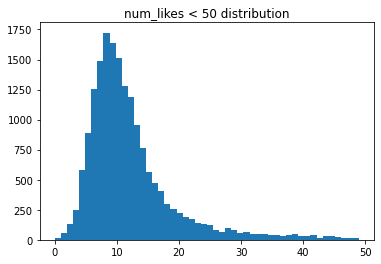

In [12]:
df[df[target]<50][target].hist(bins=50, grid=False)
plt.title('num_likes < 50 distribution')
plt.show()

In [13]:
# turn y into labels 0 and 1, given a threshold
threshold = np.quantile(y, 0.7)
threshold

13.0

In [14]:
print(f'Our threshold corresponds to \n{100*len(y[y <= threshold])/len(y):.2f}% of the stories being "bad", \n{100*len(y[y > threshold])/len(y):.2f}% of the stories being "good".')

Our threshold corresponds to 
71.03% of the stories being "bad", 
28.97% of the stories being "good".


In [15]:
from sklearn.preprocessing import Binarizer

bn = Binarizer(threshold=threshold).fit(df[[target]])
y = bn.transform(df[[target]])

In [16]:
# log transform for relevant distributions
for var_to_log in ['sent_avg_length', 'num_unique_words', 'emotion_love']:
    X.loc[:, var_to_log] = X.loc[:, var_to_log].apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Split

In [17]:
from sklearn.model_selection import train_test_split

test_size = 20/100

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=42, 
                                                   stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14598, 68), (3650, 68), (14598, 1), (3650, 1))

In [19]:
X_train_gen = X_train[numerical+categories]
X_test_gen = X_test[numerical+categories]

In [20]:
X_train_tfidf = X_train[['text_str_lem']]
X_test_tfidf  = X_test[['text_str_lem']]

In [23]:
y_train = y_train.ravel()
y_test = y_test.ravel()

# Help functions

In [93]:
def display_model_results(model, X_train, X_test, y_train, y_test, name_model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # display R2
  print(f'R2 on train set: {model.score(X_train, y_train)}')
  print(f'R2 on test set: {model.score(X_test, y_test)}')
  print('\n')

  # classification report
  print(classification_report(y_test, y_pred))
  print('\n')

  # confusion matric
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  print('\n')

  # roc
  y_probs = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
  auc = roc_auc_score(y_test, y_probs)

  plt.figure(figsize=(10,10))
  plt.plot(fpr, tpr, label=f'{name_model}, AUC={auc:.4f}')
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title("Receiver operating characteristic ")
  plt.xlabel('rate of false positives')
  plt.ylabel('rate of true positives')
  plt.legend(loc='best')
  plt.show()
  print('\n')

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')

  print('\n')


  # feature importance
  try:
    cols = [x for _, x in sorted(zip(model.coef_.tolist()[0], X_train.columns))]
    plt.figure(figsize=(15,15))
    for col, coef in zip(cols, sorted(model.coef_.tolist()[0])):
      plt.barh(col, coef)
  except AttributeError:
    print('No feature importance')
  return model


In [94]:
def play_with_threshold(recall_value, X_test, y_test, model, name):
  """
  Model must be trained
  """
  y_probs = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

  x = np.linspace(0,1, num=len(precision))
  y = interp1d(recall, precision)
  precision_value = y(recall_value)
  plt.figure(figsize=(10,10))
  plt.plot(recall, precision, label=name)
  plt.title("precision-recall curve")
  plt.plot(x, [precision_value]*len(recall), label=f'{precision_value:.2f}')
  plt.axvline(recall_value, label=f'{recall_value:.2f}')
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.legend()
  plt.show()

  if len(thresholds)<len(recall):
    thresholds = np.append(thresholds,0)
  y_thresholds = interp1d(recall, thresholds)
  threshold_value = y_thresholds(recall_value)
  print('\n')
  print(f'When recall is equal to {recall_value:.2f}, precision is equal to {precision_value:.4f},\
and the threshold is equal to {threshold_value:.2f}.')
  f1 = 2*(recall_value*precision_value)/(recall_value+precision_value)
  print(f'f1 is equal to {f1:.4f}')
  
  return threshold_value


In [95]:
def conf_matrix(model, threshold_proba, X_test, y_test):
  p = threshold_proba
  y_probs = model.predict_proba(X_test)[:,1]

  y_pred = (y_probs >= p).astype(int)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f'{tp*100/(tp+fn):.2f}% of the good stories are rightly identified.')
  print(f'{fp*100/(fp+tn):.2f}% of the bad stories are identified as good ones.')
  print('\n')
  print(f"Confusion matrix when p={p:.2f}:")
  print(confusion_matrix(y_test, y_pred))


In [128]:
def plot_rocs(names, models, X_test, y_test):
  
  plt.figure(figsize=(10, 7))
  
  for name, model in zip(names, models):
    y_probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name}, AUC={auc:.4f}')
      
  plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="no model. AUC=.5")
  plt.title('ROC curves\n(Receiver Operating Characteristic)')
  plt.xlabel('rate of false positives\nFPR')
  plt.ylabel('rate of true positives\nTPR')
  plt.legend(loc='best')
  plt.show()

# General features

## Preprocessing

In [21]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_gen = pd.DataFrame(scaler.fit_transform(X_train_gen), columns=X_train_gen.columns)
X_test_gen = pd.DataFrame(scaler.transform(X_test_gen), columns=X_train_gen.columns)

X_train_gen.shape, X_test_gen.shape

((14598, 69), (3650, 69))

## Predictions

### Logistic regression

R2 on train set: 0.7112618166872174
R2 on test set: 0.7087671232876712


              precision    recall  f1-score   support

           0       0.71      0.98      0.83      2592
           1       0.47      0.04      0.07      1058

    accuracy                           0.71      3650
   macro avg       0.59      0.51      0.45      3650
weighted avg       0.64      0.71      0.61      3650



Confusion matrix:
[[2544   48]
 [1015   43]]




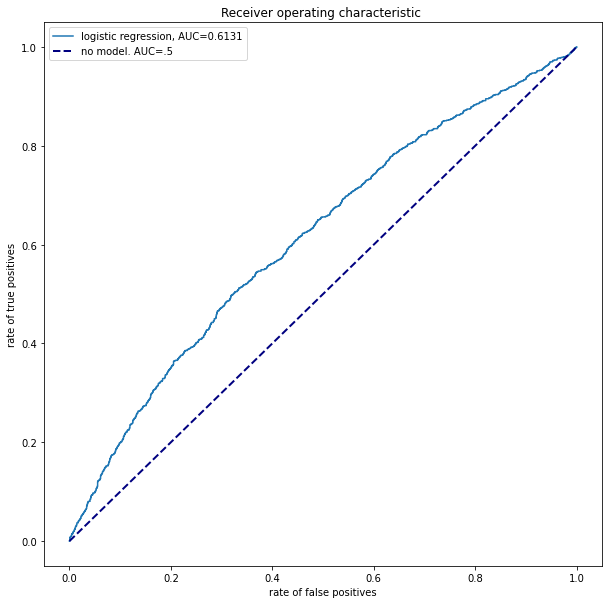



4.06% of the good stories are rightly identified.
1.85% of the bad stories are identified as good ones.




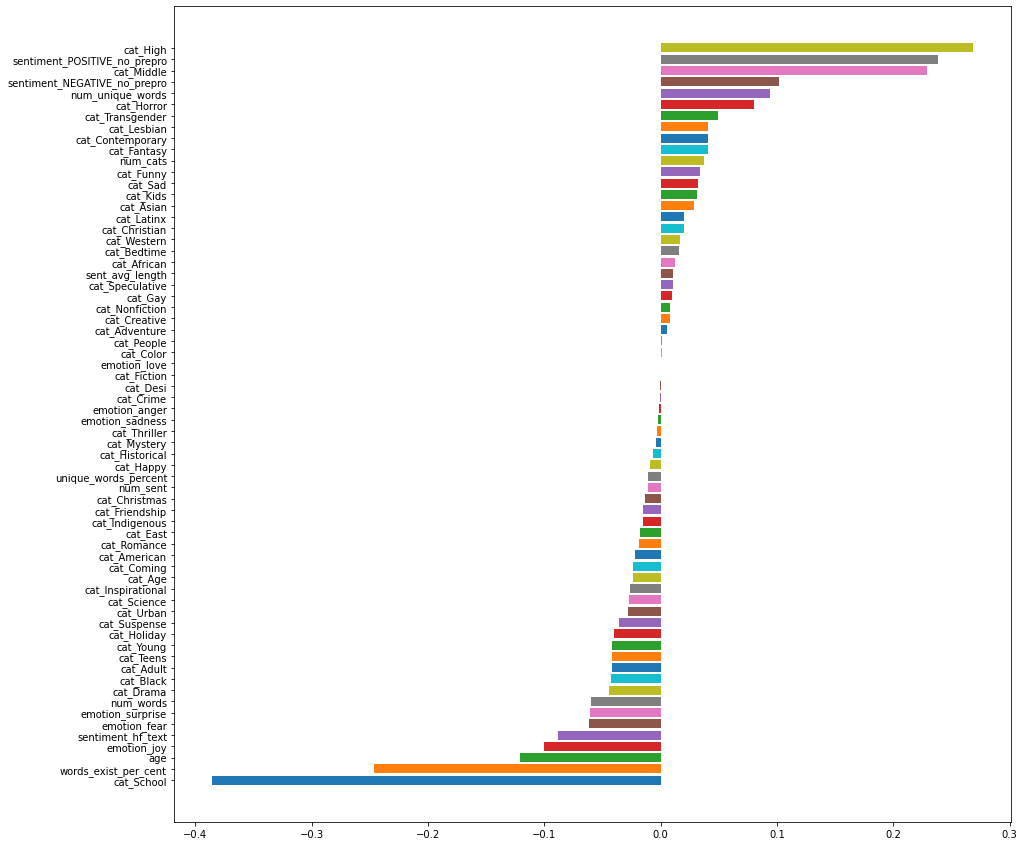

In [134]:
clf_log_gen = display_model_results(LogisticRegression(random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'logistic regression')

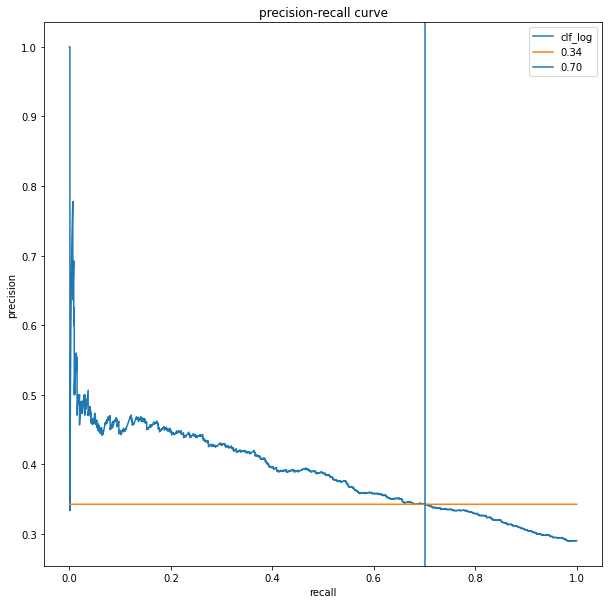



When recall is equal to 0.70, precision is equal to 0.3425,and the threshold is equal to 0.26.
f1 is equal to 0.4599


In [135]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_log_gen, 'clf_log')

### KNN 

k that minimizes the validation set error: 18


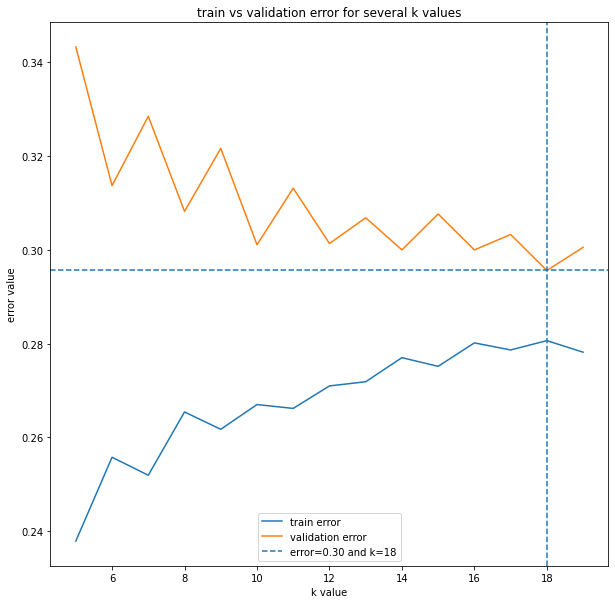

In [136]:
errors_train = []
errors_val = []
k_values = list(range(5, 20))

for k in k_values:
  neigh = KNeighborsClassifier(k)
  neigh.fit(X_train_gen, y_train)
  error_train = 1 - neigh.score(X_train_gen, y_train) 
  error_val   = 1 - neigh.score(X_test_gen, y_test) 
  errors_train.append(error_train)
  errors_val.append(error_val)

k_best = k_values[errors_val.index(min(errors_val))]
plt.figure(figsize=(10,10))
plt.plot(k_values, errors_train, label='train error')
plt.plot(k_values, errors_val, label='validation error')
plt.axhline(y = min(errors_val), linestyle = '--', label=f'error={min(errors_val):.2f} and k={k_best}')
plt.axvline(x=k_best, linestyle = '--')
plt.xlabel('k value')
plt.ylabel('error value')
plt.title('train vs validation error for several k values')
plt.legend()

print(f'k that minimizes the validation set error: {k_best}')

R2 on train set: 0.7193451157692835
R2 on test set: 0.7043835616438356


              precision    recall  f1-score   support

           0       0.71      0.97      0.82      2592
           1       0.41      0.05      0.09      1058

    accuracy                           0.70      3650
   macro avg       0.56      0.51      0.46      3650
weighted avg       0.63      0.70      0.61      3650



Confusion matrix:
[[2520   72]
 [1007   51]]




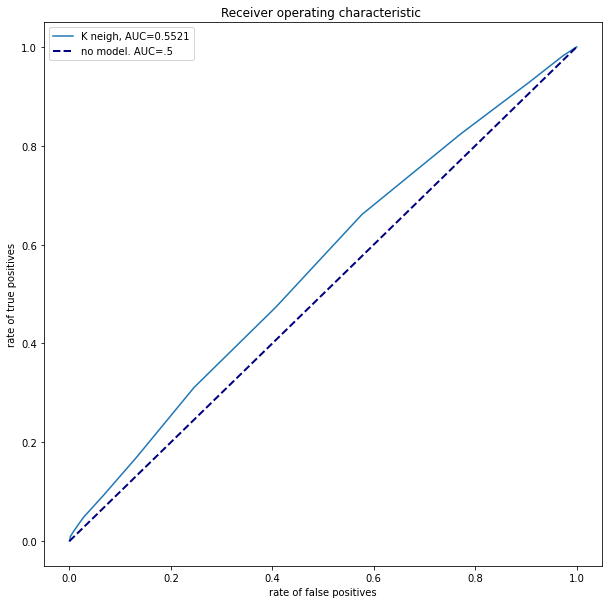



4.82% of the good stories are rightly identified.
2.78% of the bad stories are identified as good ones.


No feature importance


In [137]:
clf_neigh_gen = display_model_results(KNeighborsClassifier(n_neighbors=k_best), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'K neigh')

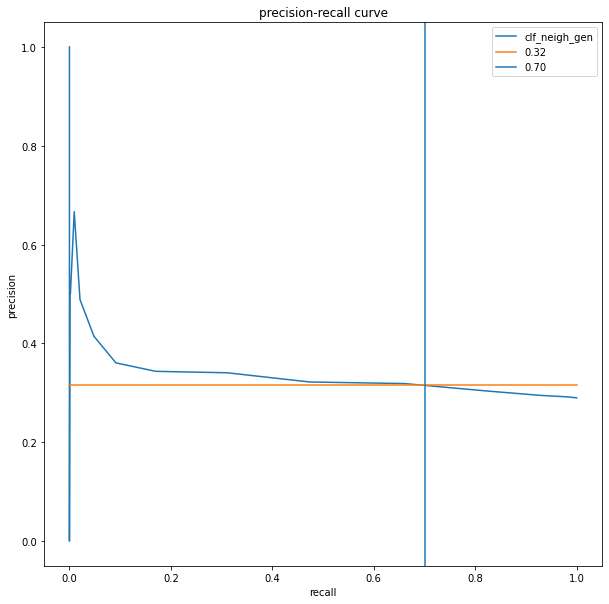



When recall is equal to 0.70, precision is equal to 0.3151,and the threshold is equal to 0.26.
f1 is equal to 0.4346


In [138]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_neigh_gen, 'clf_neigh_gen')

### Random forest

R2 on train set: 0.7371557747636662
R2 on test set: 0.7112328767123288


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.54      0.02      0.05      1058

    accuracy                           0.71      3650
   macro avg       0.63      0.51      0.44      3650
weighted avg       0.66      0.71      0.60      3650



Confusion matrix:
[[2571   21]
 [1033   25]]




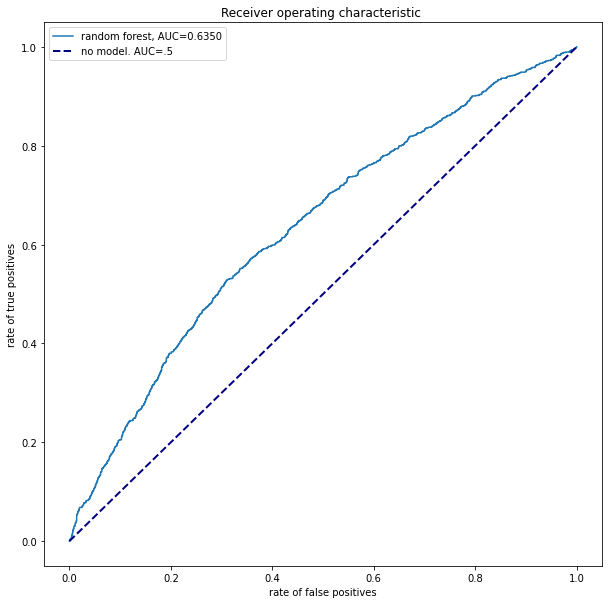



2.36% of the good stories are rightly identified.
0.81% of the bad stories are identified as good ones.


No feature importance


In [139]:
clf_rf_gen = display_model_results(RandomForestClassifier(max_depth=10, random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'random forest')

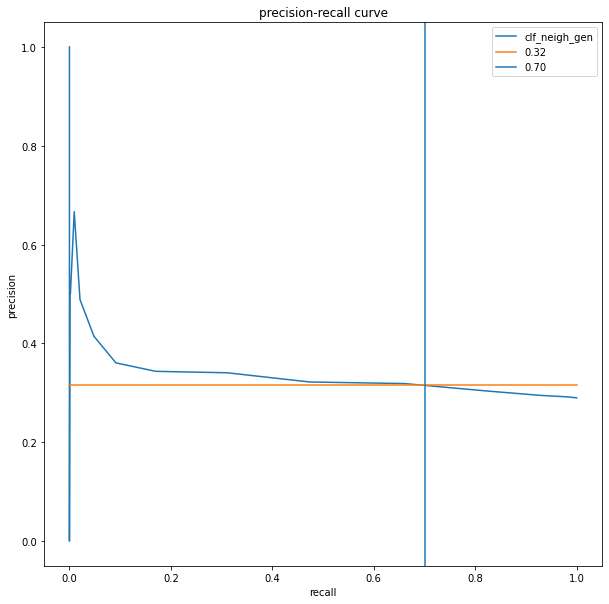



When recall is equal to 0.70, precision is equal to 0.3151,and the threshold is equal to 0.26.
f1 is equal to 0.4346


In [140]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_neigh_gen, 'clf_neigh_gen')

### Adaboost

R2 on train set: 0.7244143033292232
R2 on test set: 0.7172602739726027


              precision    recall  f1-score   support

           0       0.73      0.96      0.83      2592
           1       0.56      0.12      0.20      1058

    accuracy                           0.72      3650
   macro avg       0.64      0.54      0.51      3650
weighted avg       0.68      0.72      0.65      3650



Confusion matrix:
[[2491  101]
 [ 931  127]]




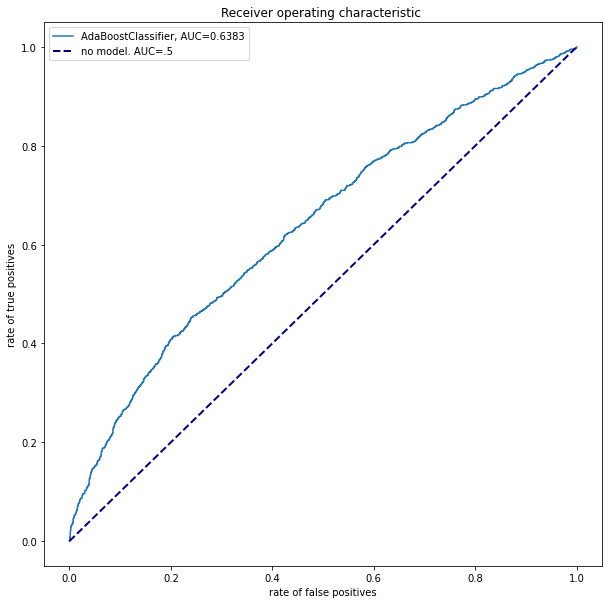



12.00% of the good stories are rightly identified.
3.90% of the bad stories are identified as good ones.


No feature importance


In [141]:
clf_ada_gen = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'AdaBoostClassifier')

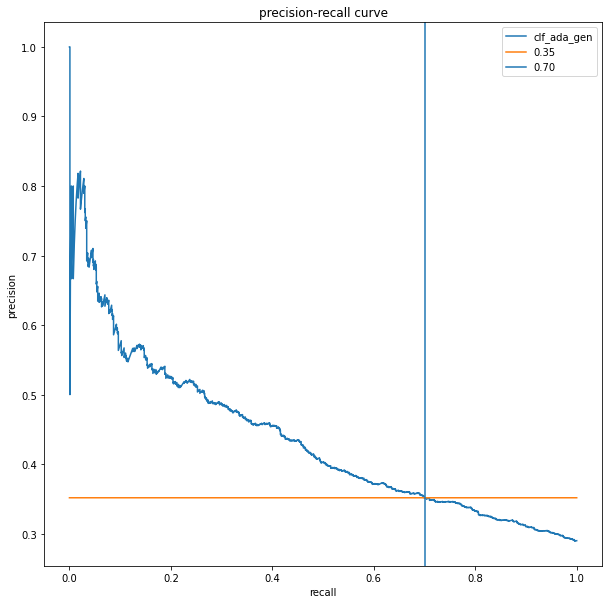



When recall is equal to 0.70, precision is equal to 0.3517,and the threshold is equal to 0.50.
f1 is equal to 0.4681


In [142]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_ada_gen, 'clf_ada_gen')

### GradientBoostingClassifier

R2 on train set: 0.7260583641594739
R2 on test set: 0.7227397260273972


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2592
           1       0.61      0.12      0.20      1058

    accuracy                           0.72      3650
   macro avg       0.67      0.54      0.52      3650
weighted avg       0.69      0.72      0.65      3650



Confusion matrix:
[[2509   83]
 [ 929  129]]




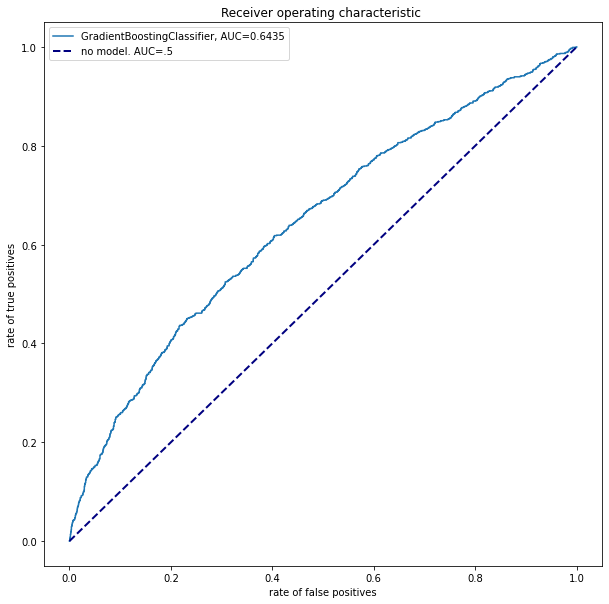



12.19% of the good stories are rightly identified.
3.20% of the bad stories are identified as good ones.


No feature importance


In [143]:
clf_gbc_gen = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'GradientBoostingClassifier')

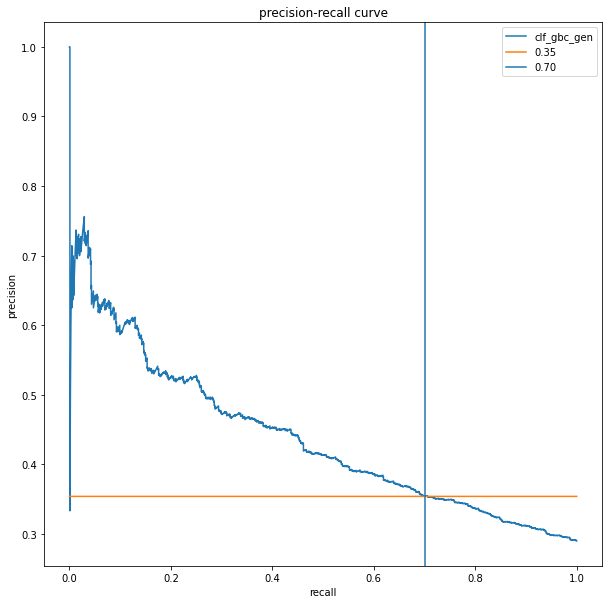



When recall is equal to 0.70, precision is equal to 0.3541,and the threshold is equal to 0.24.
f1 is equal to 0.4703


In [144]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_gbc_gen, 'clf_gbc_gen')

### HistGradientBoostingClassifier

R2 on train set: 0.7482531853678586
R2 on test set: 0.7183561643835616


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2592
           1       0.58      0.11      0.18      1058

    accuracy                           0.72      3650
   macro avg       0.65      0.54      0.50      3650
weighted avg       0.68      0.72      0.64      3650



Confusion matrix:
[[2510   82]
 [ 946  112]]




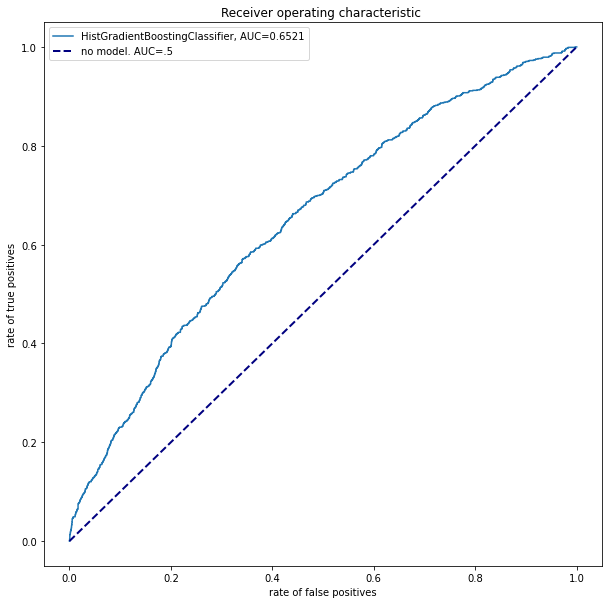



10.59% of the good stories are rightly identified.
3.16% of the bad stories are identified as good ones.


No feature importance


In [145]:
clf_hist_gen = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'HistGradientBoostingClassifier')

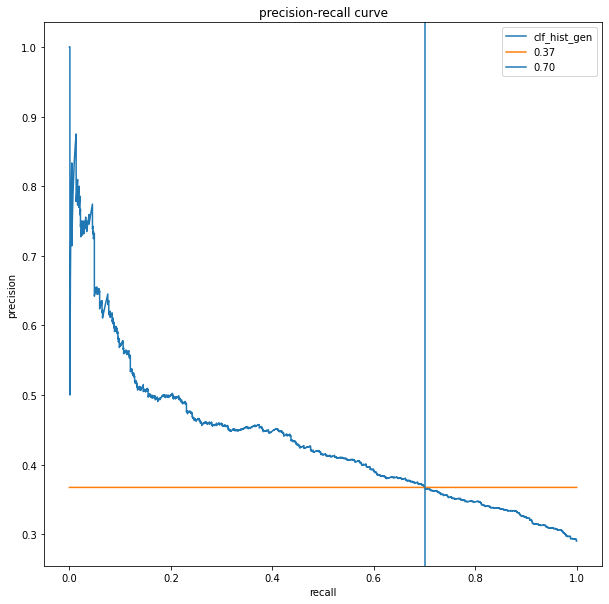



When recall is equal to 0.70, precision is equal to 0.3673,and the threshold is equal to 0.25.
f1 is equal to 0.4818


In [146]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, clf_hist_gen, 'clf_hist_gen')

In [161]:
conf_matrix(clf_hist_gen, p_threshold, X_test_gen, y_test)

49.53% of the good stories are rightly identified.
28.20% of the bad stories are identified as good ones.


Confusion matrix when p=0.31:
[[1861  731]
 [ 534  524]]


### SoftVote

In [156]:
eclf_gen = VotingClassifier(estimators=[('log', clf_log_gen), 
                                    ('neigh', clf_neigh_gen), 
                                    ('rf', clf_rf_gen), 
                                    ('ada', clf_ada_gen), 
                                    ('gbc', clf_gbc_gen)], 
                        voting='soft')

R2 on train set: 0.7242087957254418
R2 on test set: 0.7117808219178082


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.56      0.03      0.05      1058

    accuracy                           0.71      3650
   macro avg       0.63      0.51      0.44      3650
weighted avg       0.67      0.71      0.61      3650



Confusion matrix:
[[2568   24]
 [1028   30]]




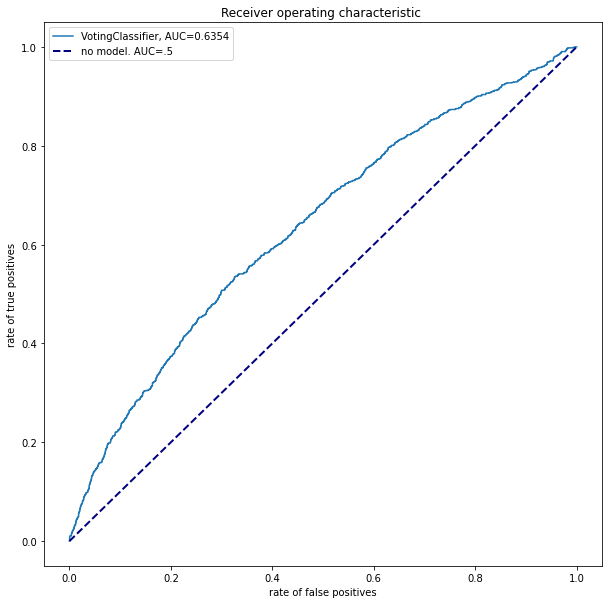



2.84% of the good stories are rightly identified.
0.93% of the bad stories are identified as good ones.


No feature importance


In [157]:
eclf_gen = display_model_results(eclf_gen, 
                      X_train_gen, X_test_gen, y_train, y_test, 
                      'VotingClassifier')

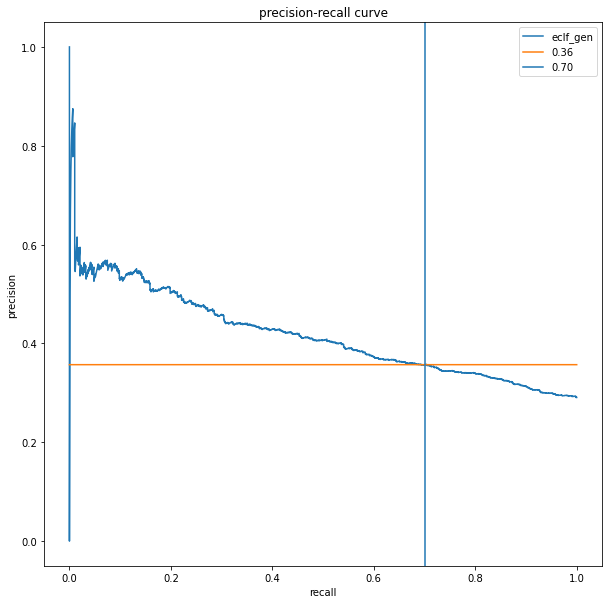



When recall is equal to 0.70, precision is equal to 0.3570,and the threshold is equal to 0.31.
f1 is equal to 0.4728


In [158]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_gen, y_test, eclf_gen, 'eclf_gen')

## ROCS

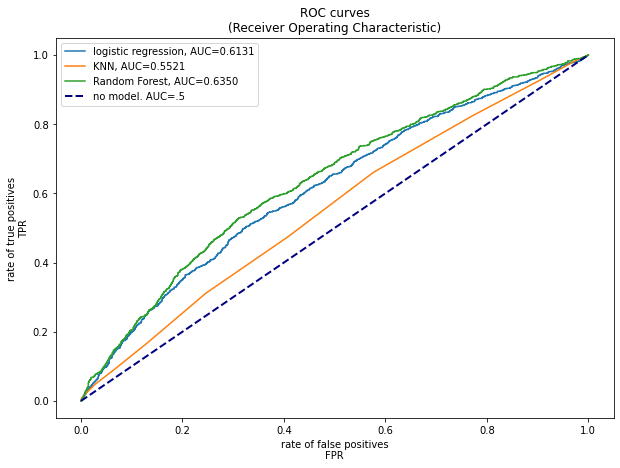

In [159]:
names = ['logistic regression', 'KNN', 'Random Forest']
models = [clf_log_gen, clf_neigh_gen, clf_rf_gen]
plot_rocs(names, models, X_test_gen, y_test)

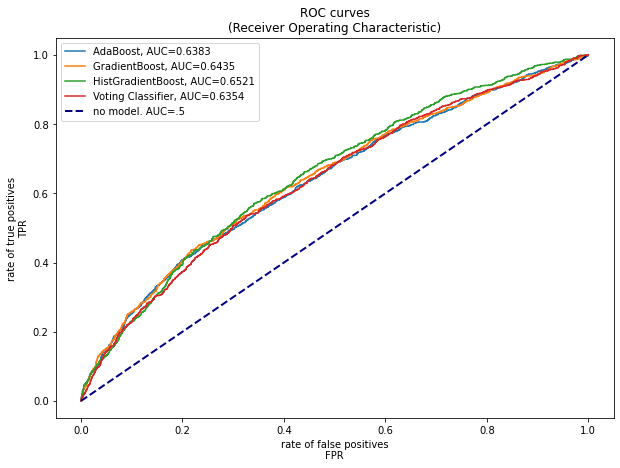

In [160]:
names = ['AdaBoost', 'GradientBoost', 'HistGradientBoost', 'Voting Classifier']
models = [clf_ada_gen, clf_gbc_gen, clf_hist_gen, eclf_gen]
plot_rocs(names, models, X_test_gen, y_test)

# TF/IDF only

## Preprocessing

In [34]:
lemmas_train = X_train_tfidf.text_str_lem.tolist()
lemmas_test = X_test_tfidf.text_str_lem.tolist()


In [35]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000
vectorizer = TfidfVectorizer(ngram_range=(1,3), 
                             max_features=max_features,
                             stop_words={'english'},
                             norm='l2')


vectorizer.fit(lemmas_train)

CPU times: user 3min 2s, sys: 3.87 s, total: 3min 6s
Wall time: 3min 8s


In [36]:
%%time

X_train_tfidf = pd.DataFrame(vectorizer.transform(lemmas_train).toarray())
X_test_tfidf = pd.DataFrame(vectorizer.transform(lemmas_test).toarray())

X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape

CPU times: user 1min 26s, sys: 243 ms, total: 1min 27s
Wall time: 1min 27s


In [37]:
scaler = StandardScaler()
X_train_tfidf = pd.DataFrame(scaler.fit_transform(X_train_tfidf))
X_test_tfidf = pd.DataFrame(scaler.transform(X_test_tfidf))


## Predictions

### Log regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


R2 on train set: 1.0
R2 on test set: 0.5783561643835616


              precision    recall  f1-score   support

           0       0.72      0.67      0.69      2592
           1       0.30      0.34      0.32      1058

    accuracy                           0.58      3650
   macro avg       0.51      0.51      0.51      3650
weighted avg       0.60      0.58      0.59      3650



Confusion matrix:
[[1748  844]
 [ 695  363]]




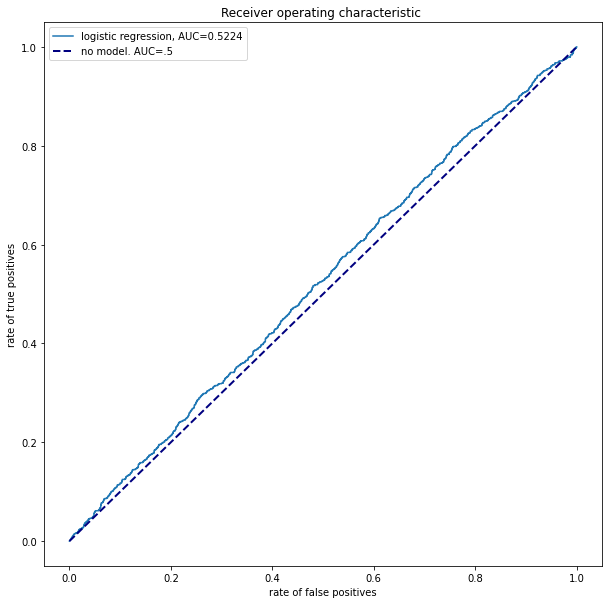



34.31% of the good stories are rightly identified.
32.56% of the bad stories are identified as good ones.




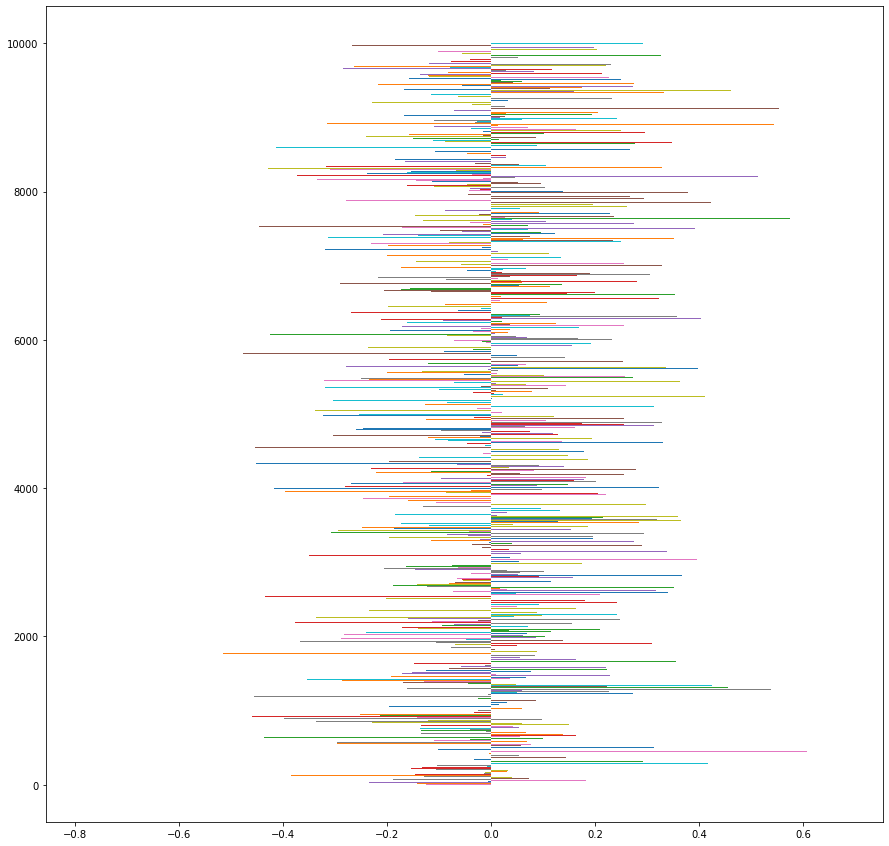

In [46]:
clf_log_tfidf = display_model_results(LogisticRegression(random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'logistic regression')

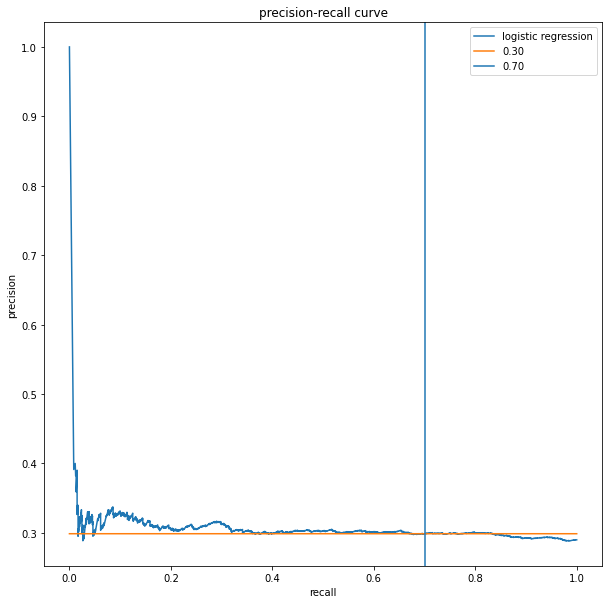



When recall is equal to 0.70, precision is equal to 0.2988,and the threshold is equal to 0.00.
f1 is equal to 0.4188


In [97]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_log_tfidf, 'logistic regression')

### SVM

In [ ]:
# takes too much time
# clf_svm = display_model_results(SVC(probability=False, ), 
#                       X_train, X_test, y_train, y_test, 
#                       'SVM')

In [ ]:
# recall_value = 0.5 # chose wanted recall value
# play_with_threshold(recall_value, y_test, clf_svm, 'svm')

### KNN

R2 on train set: 0.7148924510206878
R2 on test set: 0.7057534246575342


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.28      0.01      0.02      1058

    accuracy                           0.71      3650
   macro avg       0.49      0.50      0.42      3650
weighted avg       0.58      0.71      0.59      3650



Confusion matrix:
[[2566   26]
 [1048   10]]




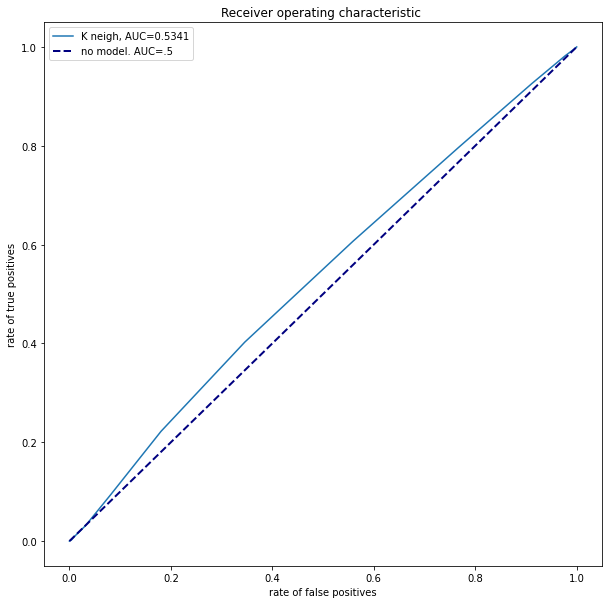



0.95% of the good stories are rightly identified.
1.00% of the bad stories are identified as good ones.


No feature importance


In [51]:
clf_neigh_tfidf = display_model_results(KNeighborsClassifier(n_neighbors=20), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'K neigh')

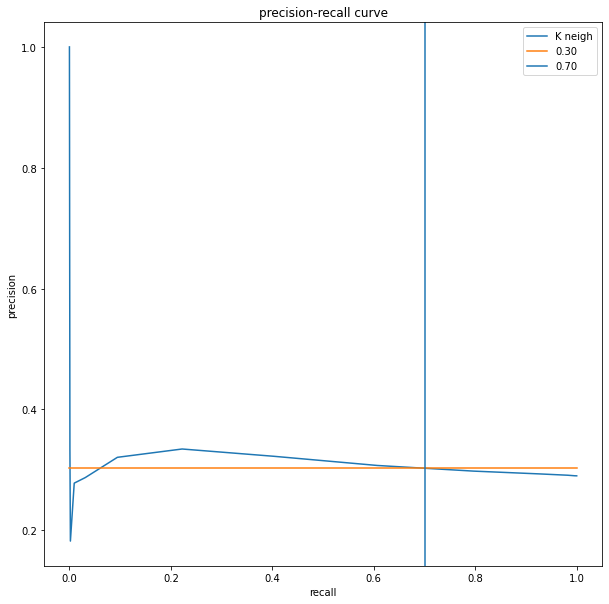



When recall is equal to 0.70, precision is equal to 0.3024,and the threshold is equal to 0.28.
f1 is equal to 0.4224


In [98]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_neigh_tfidf, 'K neigh')

### Random forest

R2 on train set: 0.7103027812029045
R2 on test set: 0.7101369863013699


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


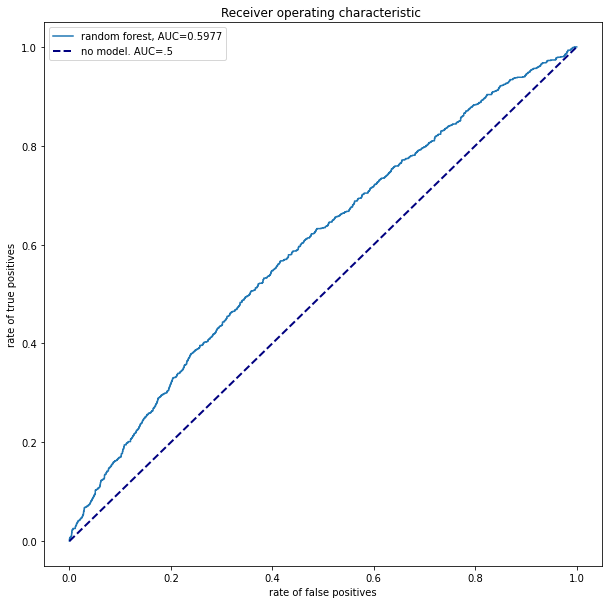



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.


No feature importance


In [60]:
clf_rf_tfidf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'random forest')

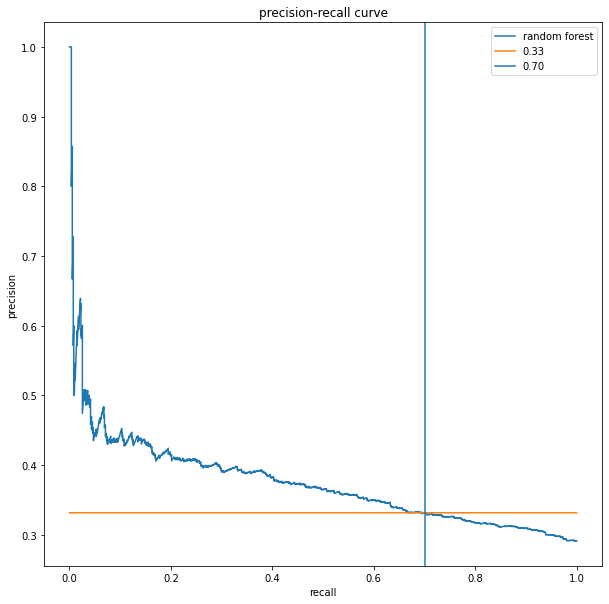



When recall is equal to 0.70, precision is equal to 0.3312,and the threshold is equal to 0.28.
f1 is equal to 0.4496


In [162]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_rf_tfidf, 'random forest')


In [163]:
conf_matrix(clf_rf_tfidf, p_threshold, X_test_tfidf, y_test)

69.94% of the good stories are rightly identified.
57.68% of the bad stories are identified as good ones.


Confusion matrix when p=0.28:
[[1097 1495]
 [ 318  740]]


### Together on ROC graph

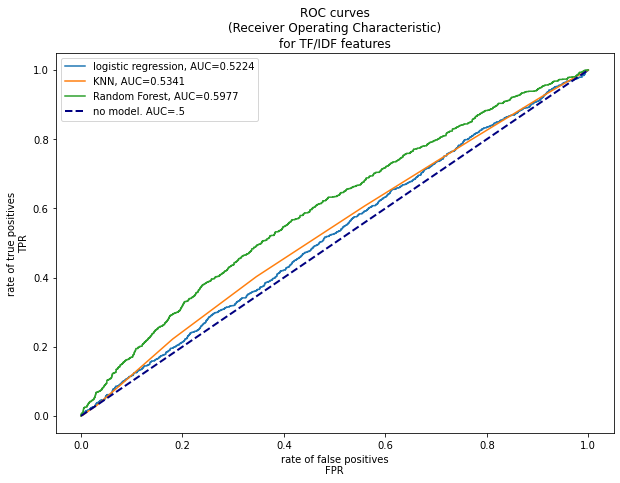

In [87]:
names = ['logistic regression', 'KNN', 'Random Forest']
models = [clf_log_tfidf, clf_neigh_tfidf, clf_rf_tfidf]
plot_rocs(names, models, X_test_tfidf, y_test)

### Adaboost

In [88]:
from sklearn.ensemble import AdaBoostClassifier

R2 on train set: 0.7340046581723524
R2 on test set: 0.6898630136986301


              precision    recall  f1-score   support

           0       0.72      0.91      0.81      2592
           1       0.41      0.16      0.22      1058

    accuracy                           0.69      3650
   macro avg       0.57      0.53      0.52      3650
weighted avg       0.63      0.69      0.64      3650



Confusion matrix:
[[2354  238]
 [ 894  164]]




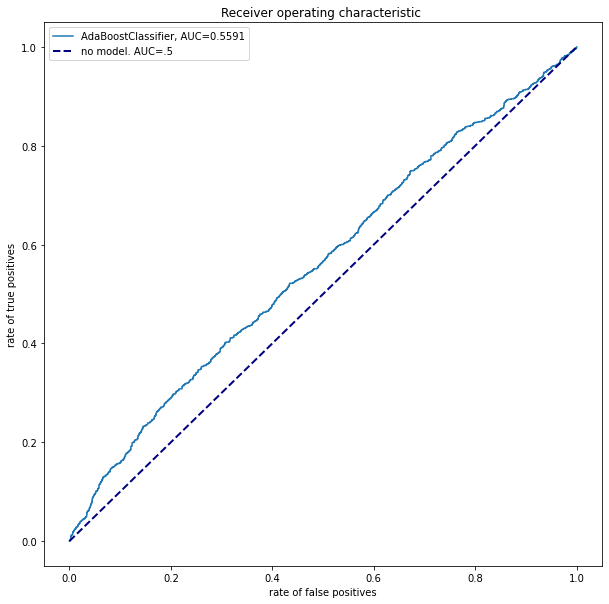



15.50% of the good stories are rightly identified.
9.18% of the bad stories are identified as good ones.


No feature importance


In [89]:
clf_ada_tfidf = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'AdaBoostClassifier')

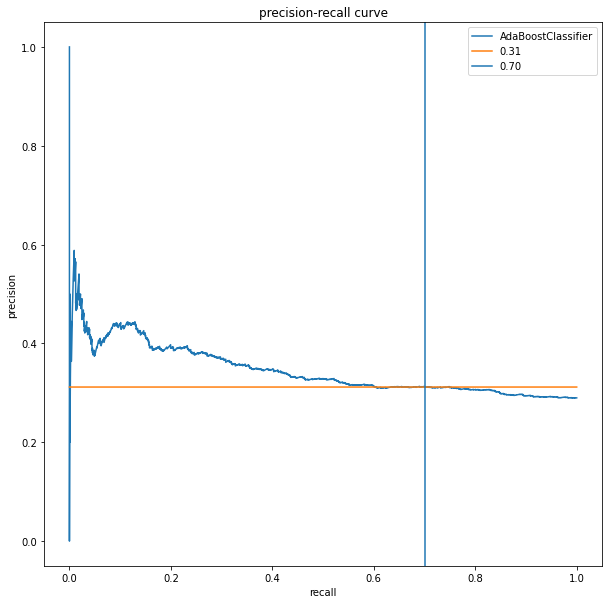



When recall is equal to 0.70, precision is equal to 0.3117,and the threshold is equal to 0.50.
f1 is equal to 0.4314


In [100]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_ada_tfidf, 'AdaBoostClassifier')


### GradientBoostingClassifier

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

R2 on train set: 0.7430469927387313
R2 on test set: 0.6854794520547945


              precision    recall  f1-score   support

           0       0.72      0.91      0.80      2592
           1       0.38      0.14      0.20      1058

    accuracy                           0.69      3650
   macro avg       0.55      0.52      0.50      3650
weighted avg       0.62      0.69      0.63      3650



Confusion matrix:
[[2355  237]
 [ 911  147]]




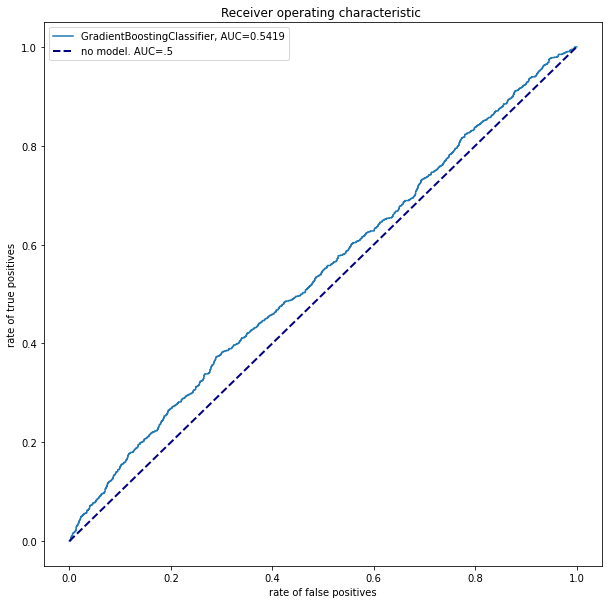



13.89% of the good stories are rightly identified.
9.14% of the bad stories are identified as good ones.


No feature importance


In [101]:
clf_gbc_tfidf = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'GradientBoostingClassifier')

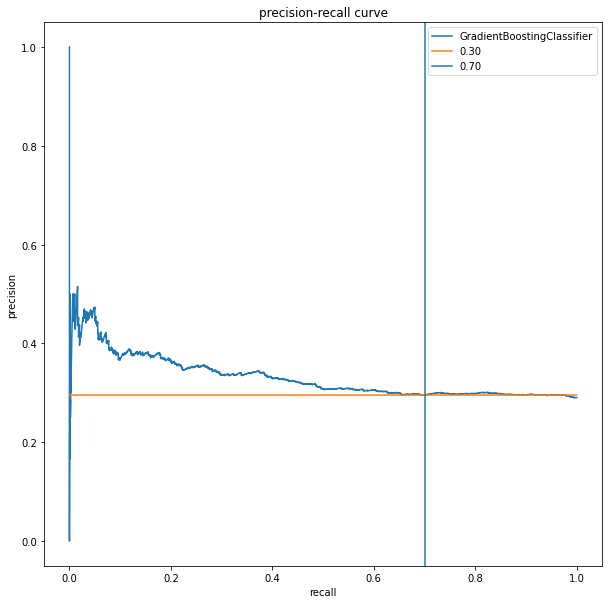



When recall is equal to 0.70, precision is equal to 0.2955,and the threshold is equal to 0.19.
f1 is equal to 0.4156


In [102]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_gbc_tfidf, 'GradientBoostingClassifier')


In [ ]:
conf_matrix(clf_gbc_tfidf, p_threshold, X_test_tfidf, y_test)

### HistGradientBoostingClassifier

In [103]:
from sklearn.ensemble import HistGradientBoostingClassifier

R2 on train set: 0.7697629812303055
R2 on test set: 0.7071232876712329


              precision    recall  f1-score   support

           0       0.71      0.98      0.83      2592
           1       0.45      0.04      0.08      1058

    accuracy                           0.71      3650
   macro avg       0.58      0.51      0.45      3650
weighted avg       0.64      0.71      0.61      3650



Confusion matrix:
[[2536   56]
 [1013   45]]




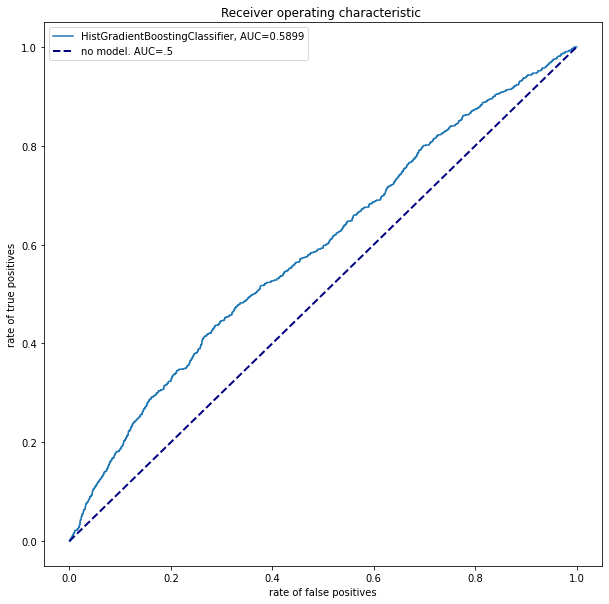



4.25% of the good stories are rightly identified.
2.16% of the bad stories are identified as good ones.


No feature importance


In [104]:
clf_hist_tfidf = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'HistGradientBoostingClassifier')

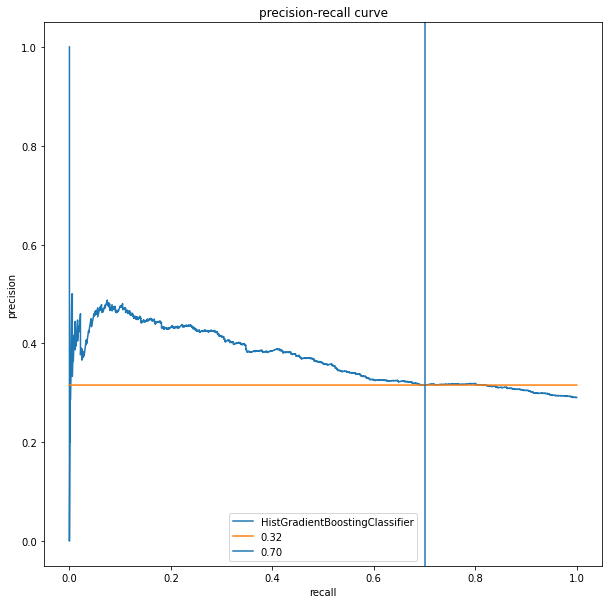



When recall is equal to 0.70, precision is equal to 0.3157,and the threshold is equal to 0.24.
f1 is equal to 0.4352


In [105]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, clf_hist_tfidf, 'HistGradientBoostingClassifier')


### Soft vote

In [106]:
from sklearn.ensemble import VotingClassifier

In [107]:
from sklearn.ensemble import VotingClassifier

eclf_tfidf = VotingClassifier(estimators=[('log', clf_log_tfidf),                   
                                          ('neigh', clf_neigh_tfidf), 
                                          ('rf', clf_rf_tfidf), 
                                          ('ada', clf_ada_tfidf), 
                                          ('gbc', clf_gbc_tfidf)], 
                              voting='soft')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


R2 on train set: 0.849636936566653
R2 on test set: 0.6816438356164384


              precision    recall  f1-score   support

           0       0.71      0.92      0.80      2592
           1       0.33      0.10      0.15      1058

    accuracy                           0.68      3650
   macro avg       0.52      0.51      0.48      3650
weighted avg       0.60      0.68      0.62      3650



Confusion matrix:
[[2383  209]
 [ 953  105]]




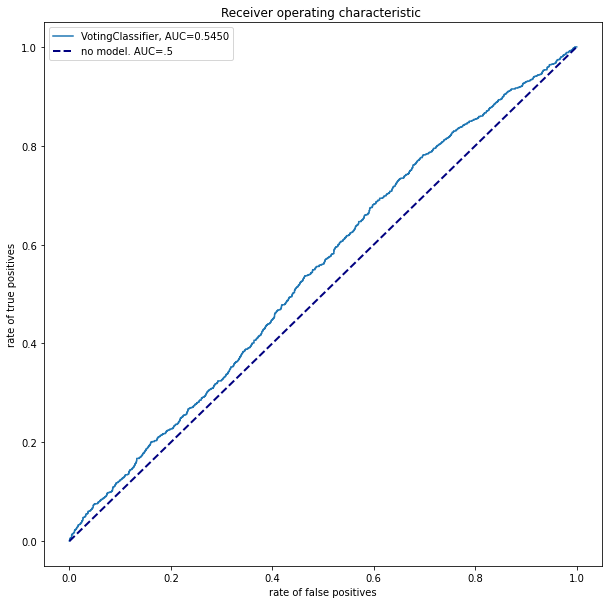



9.92% of the good stories are rightly identified.
8.06% of the bad stories are identified as good ones.


No feature importance


In [108]:
eclf_tfidf = display_model_results(eclf_tfidf, 
                      X_train_tfidf, X_test_tfidf, y_train, y_test, 
                      'VotingClassifier')

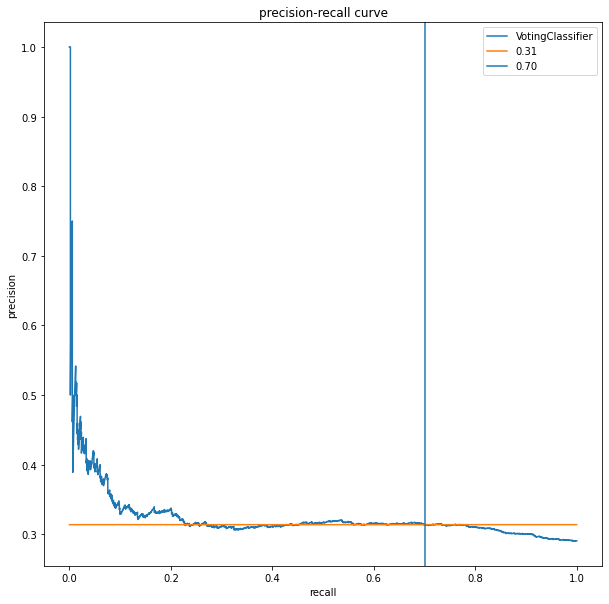



When recall is equal to 0.70, precision is equal to 0.3139,and the threshold is equal to 0.27.
f1 is equal to 0.4334


In [110]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_tfidf, y_test, eclf_tfidf, 'VotingClassifier')

# one graph with all of our ROC curves

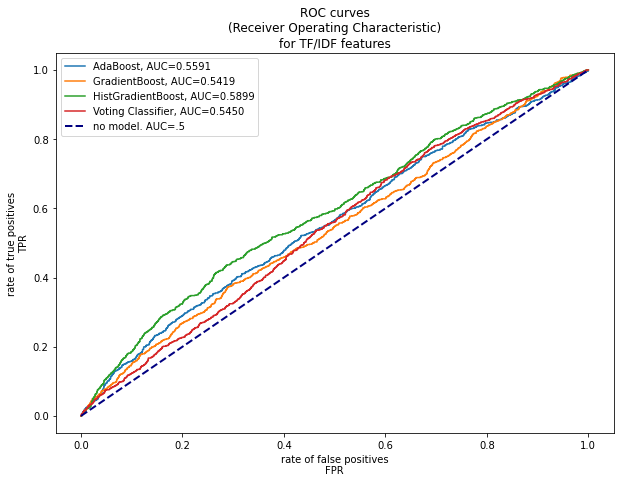

In [111]:
names = ['AdaBoost', 'GradientBoost', 'HistGradientBoost', 'Voting Classifier']
models = [clf_ada_tfidf, clf_gbc_tfidf, clf_hist_tfidf, eclf_tfidf]
plot_rocs(names, models, X_test_tfidf, y_test)

# TF/IDF and general features (ensembling)

## Preprocessing

In [112]:
X_train_all = pd.concat([X_train_gen, X_train_tfidf], axis=1)
X_test_all = pd.concat([X_test_gen, X_test_tfidf], axis=1)

X_train_gen.shape, X_train_tfidf.shape, X_train_all.shape, X_test_gen.shape, X_test_tfidf.shape, X_test_all.shape

((14598, 69),
 (14598, 10000),
 (14598, 10069),
 (3650, 69),
 (3650, 10000),
 (3650, 10069))

## Predictions

### Log regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarn

R2 on train set: 0.9999314974654062
R2 on test set: 0.5898630136986301


              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2592
           1       0.32      0.36      0.33      1058

    accuracy                           0.59      3650
   macro avg       0.52      0.52      0.52      3650
weighted avg       0.60      0.59      0.60      3650



Confusion matrix:
[[1777  815]
 [ 682  376]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


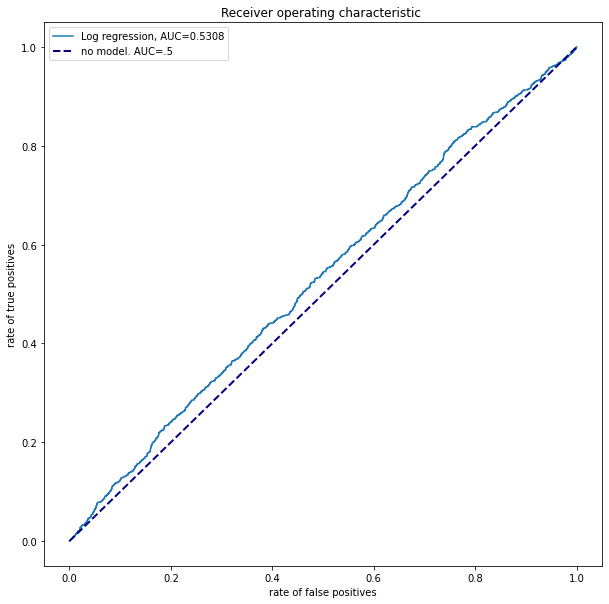



35.54% of the good stories are rightly identified.
31.44% of the bad stories are identified as good ones.




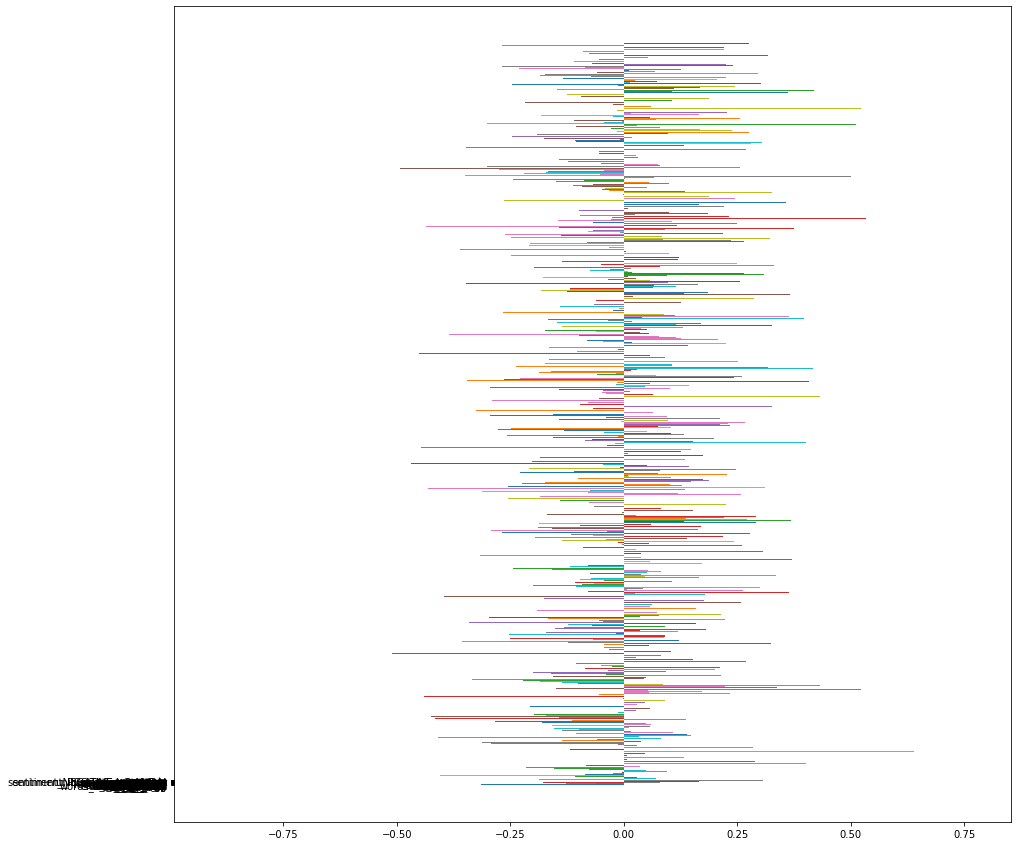

In [113]:
clf_log = display_model_results(LogisticRegression(), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'Log regression')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


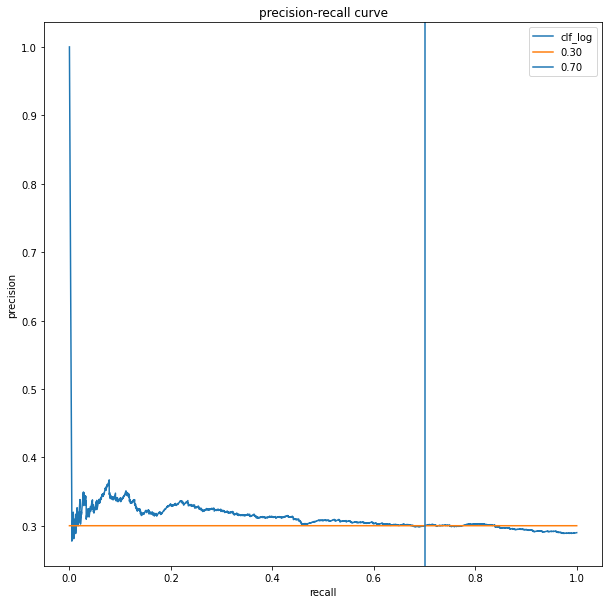



When recall is equal to 0.70, precision is equal to 0.3003,and the threshold is equal to 0.00.
f1 is equal to 0.4202


In [114]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_log, 'clf_log')

### KNN

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on train set: 0.7165365118509385


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on test set: 0.7068493150684931


              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2592
           1       0.39      0.02      0.04      1058

    accuracy                           0.71      3650
   macro avg       0.55      0.50      0.43      3650
weighted avg       0.62      0.71      0.60      3650



Confusion matrix:
[[2559   33]
 [1037   21]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


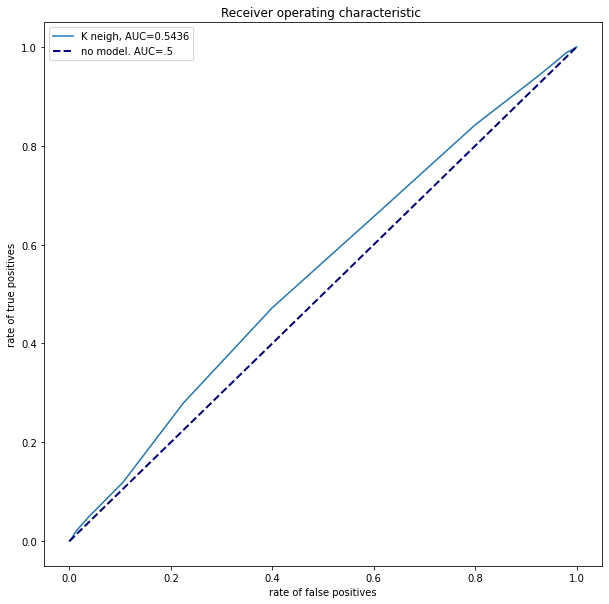



1.98% of the good stories are rightly identified.
1.27% of the bad stories are identified as good ones.


No feature importance


In [117]:
clf_neigh = display_model_results(KNeighborsClassifier(n_neighbors=20), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'K neigh')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


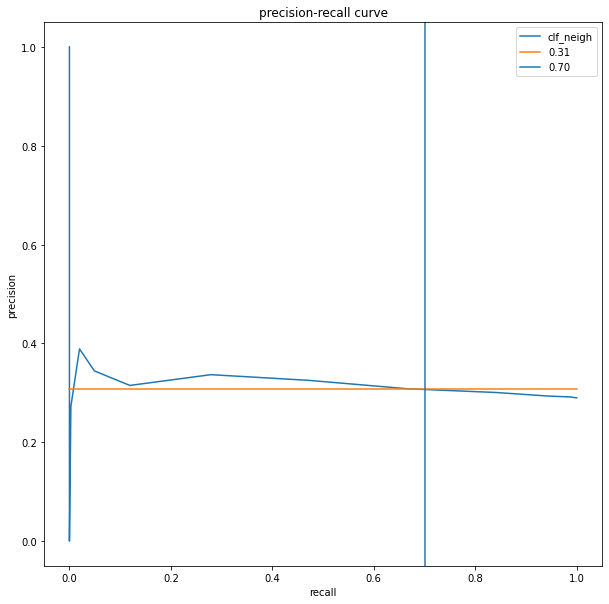



When recall is equal to 0.70, precision is equal to 0.3068,and the threshold is equal to 0.29.
f1 is equal to 0.4266


In [118]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_neigh, 'clf_neigh')

### Random forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on train set: 0.7103027812029045


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on test set: 0.7101369863013699


              precision    recall  f1-score   support

           0       0.71      1.00      0.83      2592
           1       0.00      0.00      0.00      1058

    accuracy                           0.71      3650
   macro avg       0.36      0.50      0.42      3650
weighted avg       0.50      0.71      0.59      3650



Confusion matrix:
[[2592    0]
 [1058    0]]




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:

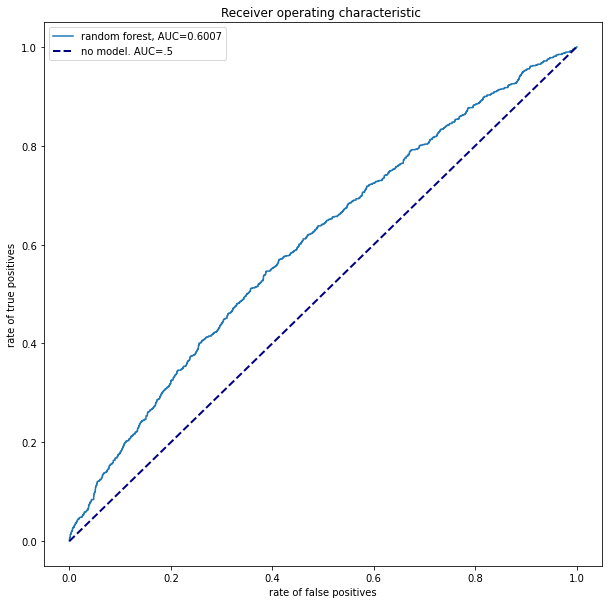



0.00% of the good stories are rightly identified.
0.00% of the bad stories are identified as good ones.


No feature importance


In [119]:
clf_rf = display_model_results(RandomForestClassifier(max_depth=5, n_jobs=-1), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'random forest')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


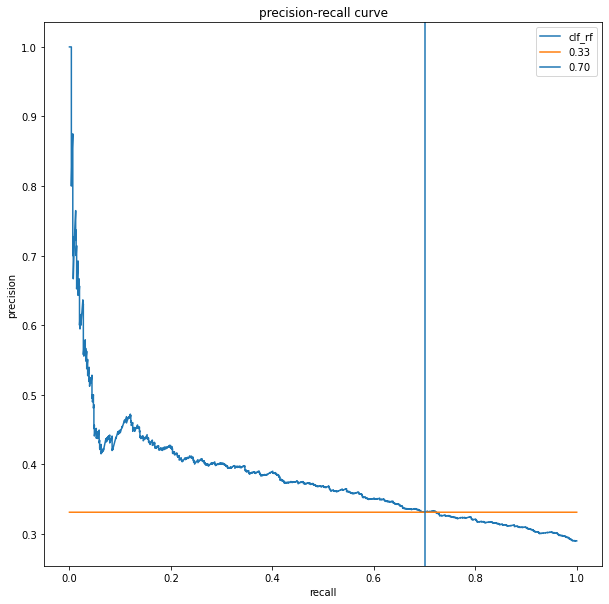



When recall is equal to 0.70, precision is equal to 0.3311,and the threshold is equal to 0.28.
f1 is equal to 0.4496


In [120]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_rf, 'clf_rf')

### Adaboost

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on train set: 0.7429784902041375


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on test set: 0.7016438356164384


              precision    recall  f1-score   support

           0       0.73      0.91      0.81      2592
           1       0.47      0.20      0.28      1058

    accuracy                           0.70      3650
   macro avg       0.60      0.55      0.54      3650
weighted avg       0.66      0.70      0.66      3650



Confusion matrix:
[[2353  239]
 [ 850  208]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


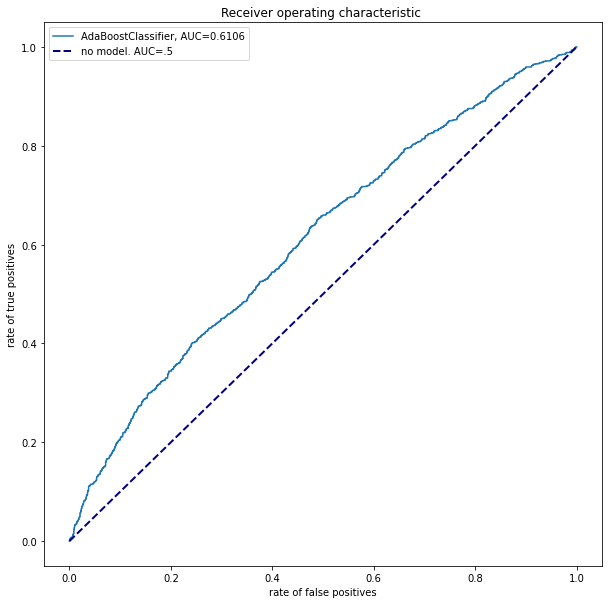



19.66% of the good stories are rightly identified.
9.22% of the bad stories are identified as good ones.


No feature importance


In [121]:
clf_ada = display_model_results(AdaBoostClassifier(n_estimators=100, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'AdaBoostClassifier')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


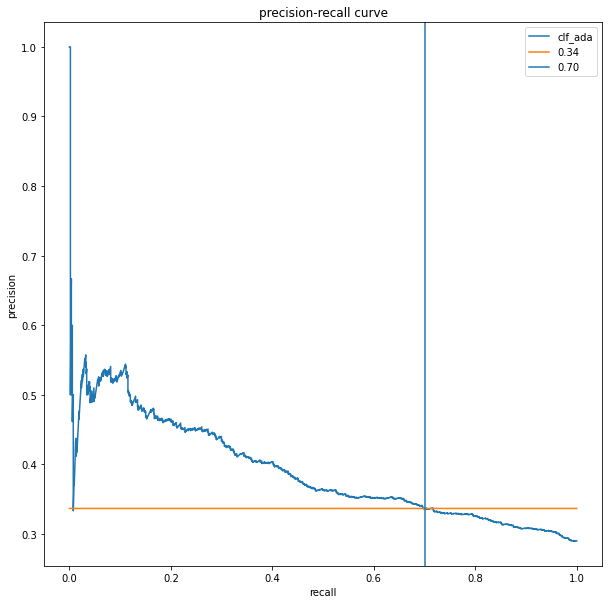



When recall is equal to 0.70, precision is equal to 0.3367,and the threshold is equal to 0.50.
f1 is equal to 0.4547


In [122]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_ada, 'clf_ada')

### GradientBoostingClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on train set: 0.7533223729277984


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on test set: 0.7043835616438356


              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2592
           1       0.47      0.19      0.27      1058

    accuracy                           0.70      3650
   macro avg       0.60      0.55      0.54      3650
weighted avg       0.66      0.70      0.66      3650



Confusion matrix:
[[2372  220]
 [ 859  199]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


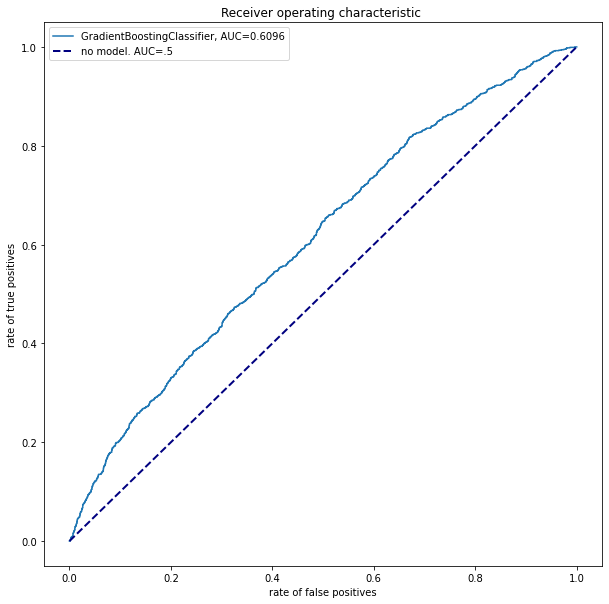



18.81% of the good stories are rightly identified.
8.49% of the bad stories are identified as good ones.


No feature importance


In [123]:
clf_gbc = display_model_results(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'GradientBoostingClassifier')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


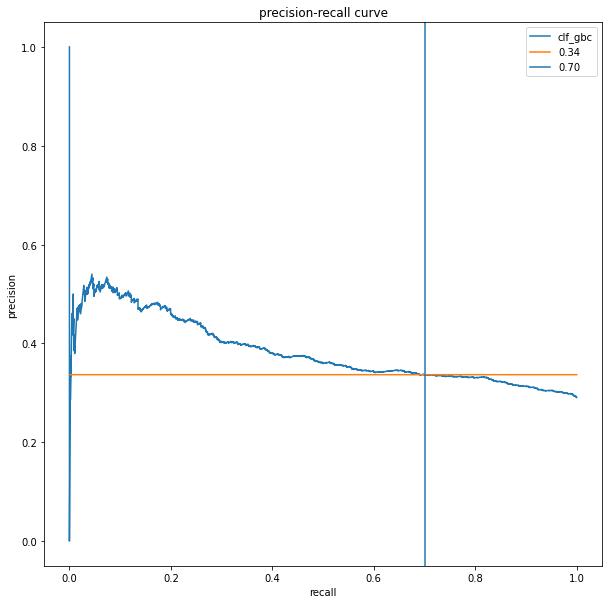



When recall is equal to 0.70, precision is equal to 0.3367,and the threshold is equal to 0.21.
f1 is equal to 0.4547


In [124]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_gbc, 'clf_gbc')

### HistGradientBoostingClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


R2 on train set: 0.8096999588984792
R2 on test set: 0.72


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2592
           1       0.59      0.11      0.19      1058

    accuracy                           0.72      3650
   macro avg       0.66      0.54      0.51      3650
weighted avg       0.69      0.72      0.65      3650



Confusion matrix:
[[2508   84]
 [ 938  120]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


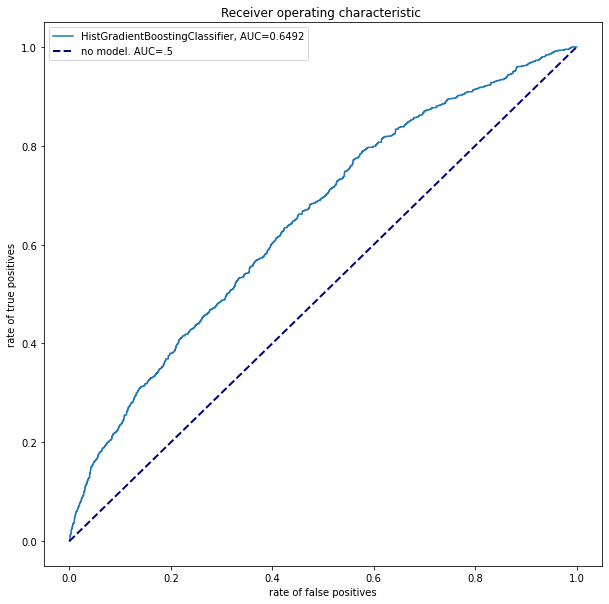



11.34% of the good stories are rightly identified.
3.24% of the bad stories are identified as good ones.


No feature importance


In [125]:
clf_hist = display_model_results(HistGradientBoostingClassifier(max_iter=100), 
                      X_train_all, X_test_all, y_train, y_test, 
                      'HistGradientBoostingClassifier')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


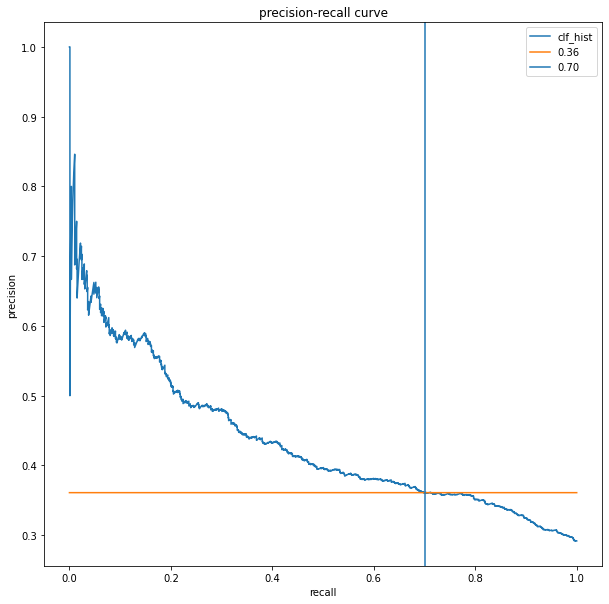



When recall is equal to 0.70, precision is equal to 0.3610,and the threshold is equal to 0.25.
f1 is equal to 0.4763


In [164]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, clf_hist, 'clf_hist')

In [165]:
conf_matrix(clf_hist, p_threshold, X_test_all, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


69.94% of the good stories are rightly identified.
50.58% of the bad stories are identified as good ones.


Confusion matrix when p=0.25:
[[1281 1311]
 [ 318  740]]


### Soft vote

In [130]:
eclf = VotingClassifier(estimators=[('log', clf_log), 
                                    ('neigh', clf_neigh), 
                                    ('rf', clf_rf), 
                                    ('ada', clf_ada), 
                                    ('gbc', clf_gbc)], 
                        voting='soft')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarn

R2 on train set: 0.8640224688313468


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

R2 on test set: 0.6928767123287671


              precision    recall  f1-score   support

           0       0.72      0.92      0.81      2592
           1       0.42      0.15      0.22      1058

    accuracy                           0.69      3650
   macro avg       0.57      0.53      0.51      3650
weighted avg       0.64      0.69      0.64      3650



Confusion matrix:
[[2373  219]
 [ 902  156]]




/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

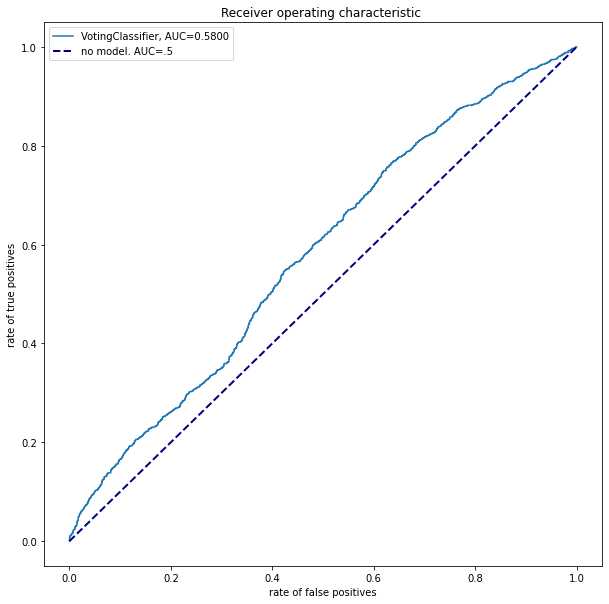



14.74% of the good stories are rightly identified.
8.45% of the bad stories are identified as good ones.


No feature importance


In [131]:
eclf = display_model_results(eclf, 
                      X_train_all, X_test_all, y_train, y_test, 
                      'VotingClassifier')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

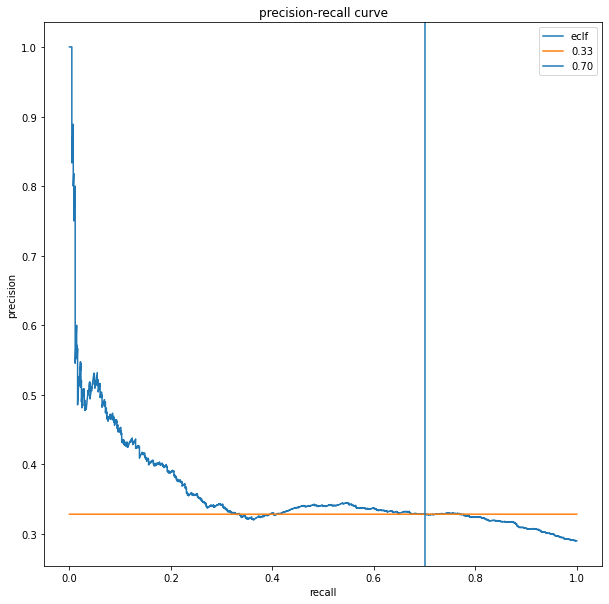



When recall is equal to 0.70, precision is equal to 0.3286,and the threshold is equal to 0.28.
f1 is equal to 0.4472


In [132]:
recall_value = 0.7 # chose wanted recall value
p_threshold = play_with_threshold(recall_value, X_test_all, y_test, eclf, 'eclf')

# one graph of all our ROC curves

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


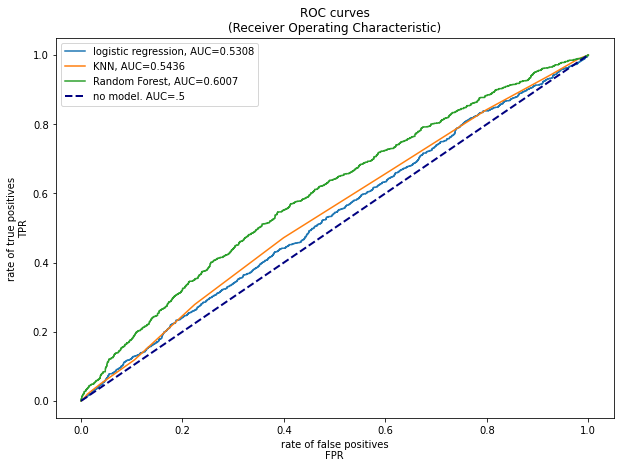

In [129]:
names = ['logistic regression', 'KNN', 'Random Forest']
models = [clf_log, clf_neigh, clf_rf]
plot_rocs(names, models, X_test_all, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

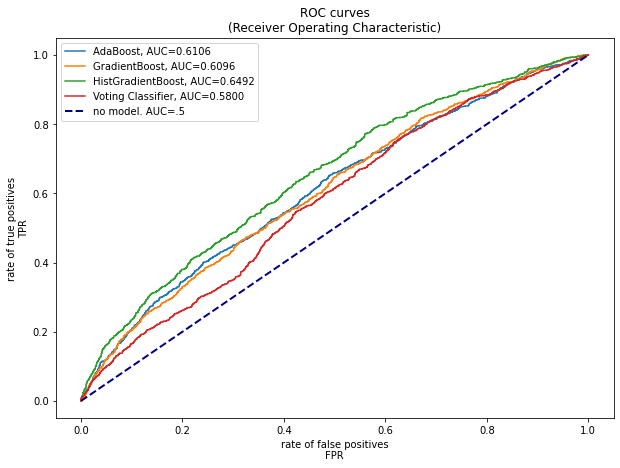

In [133]:
names = ['AdaBoost', 'GradientBoost', 'HistGradientBoost', 'Voting Classifier']
models = [clf_ada, clf_gbc, clf_hist, eclf]
plot_rocs(names, models, X_test_all, y_test)